In [7]:
"""
Outline:
  driver()
      input: dim - dimensions (2 or 3)
      output: 3D reconstructed field
  dg.field()
      Generates a 3D field of your choosen geometry 
      options: uniform, wavy
      output: Stokes U/Q 2D map to use as mock data
  multigrid()
      input: 2D mock data map, # dims
      output: 3D reconstructed field
      driver for entire code
  rf.init_recon_2D() & rf.init_recon_3D()
      input: 2D U/Q map
      output: initial 3D reconstruction of U/Q, purely from geometry.
      2D version reconstructs for essentiall a NxNx1 field, 
      with 1 element in the z direction. 
      3D version reconstructs for the full 3D field (NxNxN)
  r_vcycle():
      input: data 2D (u), restricted 2D level (u0), initial 3D reconstructed (u1), prolonged 3D (u3), dimensions (2.5 or 3)
      output: saved reconstructed to u3_list
      recursive function to restrict data and reconstruct at each level
  restrict():
      input: 2D U/Q map
      output: restricted 2D U/Q map, next level down
  p_vcycle():
      input: data 3D (u1, initially reconstructed at that level),
      guess 2D (u0, restricted map at that level), 
      reconstructed list (u3, to be saved and returned),
      J (ceiling), dim (dimensions, 2.5 or 3)
      output: prolonged field
      recursive function to prolong data at each level and return when done!
  prolong_2D() & prolong_3D():
      input: 2.5D or 3D map
      output: prolonged field
  rf.UQ_reconstruct()
      input: bx, by, bz
      output: finds stokes U/Q for each cell in the reconstructed 
      field to compare to input and find original.
  rf.residual()
      input: U, Q, Ur, Qr
      output: residual between input and reconstructed field
  rf.visualize_3d_recon() & rf.visualize_25d_recon()
      input: bx, by, bz, vector skip, vector length, name
      output: 3D vector plot of reconstructed field 
"""

'\nOutline:\n  driver()\n      input: dim - dimensions (2 or 3)\n      output: 3D reconstructed field\n  dg.field()\n      Generates a 3D field of your choosen geometry \n      options: uniform, wavy\n      output: Stokes U/Q 2D map to use as mock data\n  multigrid()\n      input: 2D mock data map, # dims\n      output: 3D reconstructed field\n      driver for entire code\n  rf.init_recon_2D() & rf.init_recon_3D()\n      input: 2D U/Q map\n      output: initial 3D reconstruction of U/Q, purely from geometry.\n      2D version reconstructs for essentiall a NxNx1 field, \n      with 1 element in the z direction. \n      3D version reconstructs for the full 3D field (NxNxN)\n  r_vcycle():\n      input: data 2D (u), restricted 2D level (u0), initial 3D reconstructed (u1), prolonged 3D (u3), dimensions (2.5 or 3)\n      output: saved reconstructed to u3_list\n      recursive function to restrict data and reconstruct at each level\n  restrict():\n      input: 2D U/Q map\n      output: restri

In [8]:
import numpy as np
import matplotlib.pyplot as plt


In [9]:
import data_gen as dg
import recon_funcs as rf
import Sampler as sampler 

In [6]:
def p_vcycle(u1_list, b3_list, J, C): # u1_list restricted 2d DATA (U, Q, cos2g), b3_list is the prolonged layers, J is the level we're on

    if len(u1_list) != 0: 
        # this needs to change below
        if J == 1: # this is for the first cell only, where u11 = u21, and skips sampling
            
            u11 = u1_list.pop() # restricted layers, act as data
            
            b11 = rf.init_recon_2D(u11) # Reconstruct restricted 1x1 square into cube

            b31 = rf.prolong_3D(b11) # prolong into 2x2x2 cube
        
            b3_list.append(b31) # save 2x2x2 cube
            
            J = b31[0][0].shape[0]

            print('[checkpoint]: 1x1 square reconstructed and prolonged.')
            p_vcycle(u1_list, b3_list, J, C)

        else:            
            u12 = u1_list.pop() # restricted 2d DATA; every time a level is used, remove
            
            b12 = rf.init_recon_3D(u12) # reconstruct nxn square into nxnxn cube
            
            b32 = b3_list[-1] # grab previously prolonged cube
            
            print('[checkpoint]: B12 shape = ', np.shape(b12), 'B32 shape = ', np.shape(b32))

            if np.shape(b12) == np.shape(b32):
                # set parameters for sampling
                dtheta   = 0.02
                dphi     = 0.3
                R        = 8000
                rbins    = R//100
                nbins    = 20
                ntrials  = 200
                burn     = 50
                plotting = 1

                # Check Level:
                if u12[0][0].shape[0] < C:  # still growing, still prolongating

                    b22 = sampler.mcmc_driver(data=b12, prolonged=b32, dtheta=dtheta, dphi=dphi, rbins=rbins, R=R, 
                                              nbins=nbins, ntrials=ntrials, burn=burn, plotting=plotting)
                    print('[checkpoint]: Sampled B shape = ', np.shape(b22))

                    b33 = rf.prolong_3D(b22)

                    print('[checkpoint]: ','B22 shape = ', np.shape(b22), 'B33 shape = ', np.shape(b33))

                    J = b33[0][0].shape[0]

                    b3_list.append(b33)

                    p_vcycle(u1_list, b3_list, J, C)

                elif u12[0][0].shape[0] == C: # Hit last level. No more prolongation, but still want to sample 
                    print(u12[0][0].shape[0])
                    # Sample last level
                    b22 = sampler.mcmc_driver(data=b12, prolonged=b32, dtheta=dtheta, dphi=dphi, rbins=rbins, R=R, 
                                              nbins=nbins, ntrials=ntrials, burn=burn, plotting=plotting)
                    
                    b3_list.append(b22)

                    print('Ceiling Hit at J = ', u12[0][0].shape[0])
                    return
                else:
                    print('You have gone past input dimensions, something is wrong.')
            else:
                print('Reconstructed and Prolonged B field shapes do not match.')

    else:
        print('All levels reached, returning...') # once on last level, return


In [5]:
def r_vcycle(tdmap, u1_list, b3_list, C):
    J = tdmap[0][0].shape[0]
    if J == 1: # check size is 1 cell
        # print('[checkpoint]: check for list of restricted layers')
        print('lvl == 1: Bottom reached; Begin Prolongation')
        p_vcycle(u1_list, b3_list, J, C) # start prolongation cycle at smallest cell

    else:
        u0 = rf.restrict(tdmap) # restrict to lower resolution
        u1_list.append(u0) # save each restricted 2D level
        r_vcycle(u0, u1_list, b3_list, C) # restart cycle for next lvl
    

In [6]:
# u0 = initial observations, restricted: u0 = restrict(u)
# u1 = initially reconstructed/sampled, acts as data: u1 = reconstruct/sample(u0)
# u2 = sampled result from u1 data and u3 as guess: u2 = sample(u3|u1)
# u3 = prolonged data, starting point/initial guess: u3 = prolong(u2)
def multigrid(u): # takes in 2D array of data, and number of runs for sampler
    C    = u[0][0].shape[0]
    print('Ceiling = ', C)
    if (C % 2 == 0):
        u1_list = [] # restricted
        b2_list = [] # sampled
        b3_list = [] # prolonged

        u1_list.append(u) # save first level

        # grab restricted lvls and initially recon lvls (u0,u1)
        r_vcycle(u, u1_list, b3_list, C) # u = data, u0 enters with saved data array, u1 enters empty.
        print('[Multigrid]: Complete.')
    
    else:
        print('[Multigrid]: J must be even: C=%4i' % (C))

    return b3_list    

Loading data...
Reconstructing in 3 Dimensions


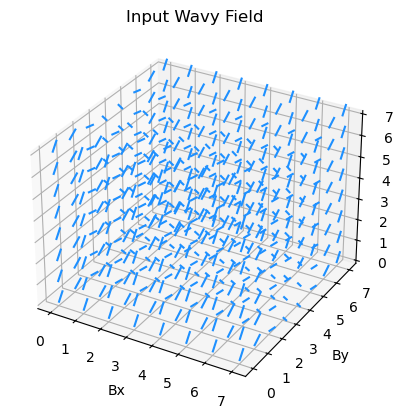

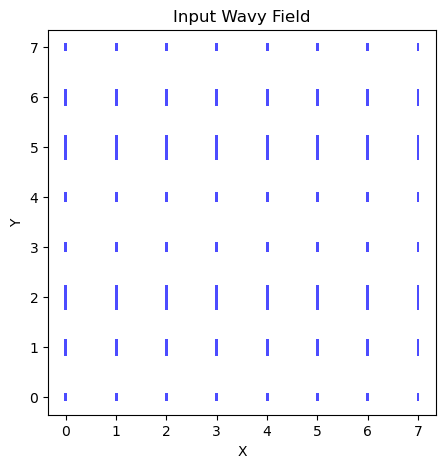

[array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0.29192658, 0.29192658, 0.29192658, 0.29192658, 0.29192658,
        0.29192658, 0.29192658, 0.29192658],
       [0.65909361, 0.65909361, 0.65909361, 0.65909361, 0.65909361,
        0.65909361, 0.65909361, 0.65909361],
       [0.95129632, 0.95129632, 0.95129632, 0.95129632, 0.95129632,
        0.95129632, 0.95129632, 0.95129632],
       [0.38545564, 0.38545564, 0.38545564, 0.38545564, 0.38545564,
        0.38545564, 0.38545564, 0.38545564],
       [0.38545564, 0.38545564, 0.38545564, 0.38545564, 0.38545564,
        0.38545564, 0.38545564, 0.38545564],
       [0.95129632, 0.95129632, 0.95129632, 0.95129632, 0.95129632,
        0.95129632, 0.95129632, 0.95

In [7]:
print('===============')
print('Loading data...')

# This is for Bz components that vary along the line of sight. Don't need to touch this until 2.5D reconstruction is working and well.
print('Reconstructing in 3 Dimensions')
UQpol_array               = dg.bz_wavy_field(amplitude=1, frequency=1, box_length=8, y_const=0, visual=1, plotdex='xy')
print(UQpol_array)
# exit()
# d3_field                  = multigrid(UQpol_array)


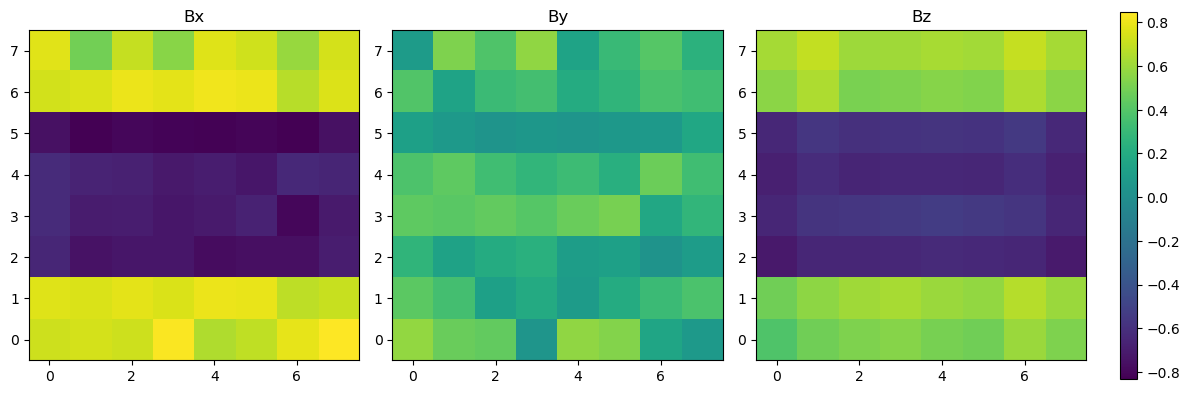

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

bx = d3_field[3][0]
by = d3_field[3][1]
bz = d3_field[3][2]

# Global min/max for consistent scale
vmin = min(bx[0].min(), by[0].min(), bz[0].min())
vmax = max(bx[0].max(), by[0].max(), bz[0].max())

# Create a gridspec with an extra column for the colorbar
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

im0 = axes[0].imshow(bx[0], vmin=vmin, vmax=vmax)
axes[0].invert_yaxis()
axes[0].set_title("Bx")

im1 = axes[1].imshow(by[0], vmin=vmin, vmax=vmax)
axes[1].invert_yaxis()
axes[1].set_title("By")

im2 = axes[2].imshow(bz[0], vmin=vmin, vmax=vmax)
axes[2].invert_yaxis()
axes[2].set_title("Bz")

# Colorbar in the 4th column
cax = fig.add_subplot(gs[0, 3])
fig.colorbar(im0, cax=cax)

plt.tight_layout()
plt.show()


In [52]:
# %matplotlib qt

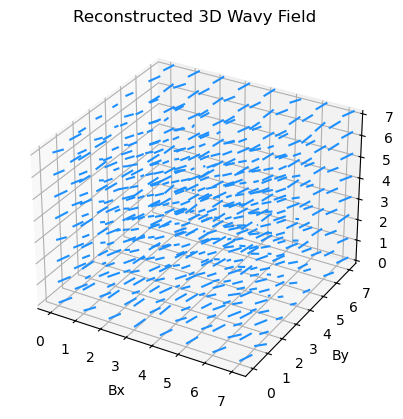

In [55]:
rf.visualize_3d(d3_field[-1][0], d3_field[-1][1], d3_field[-1][2], name='Reconstructed 3D Wavy Field', plotdex='ij')


(8, 8)


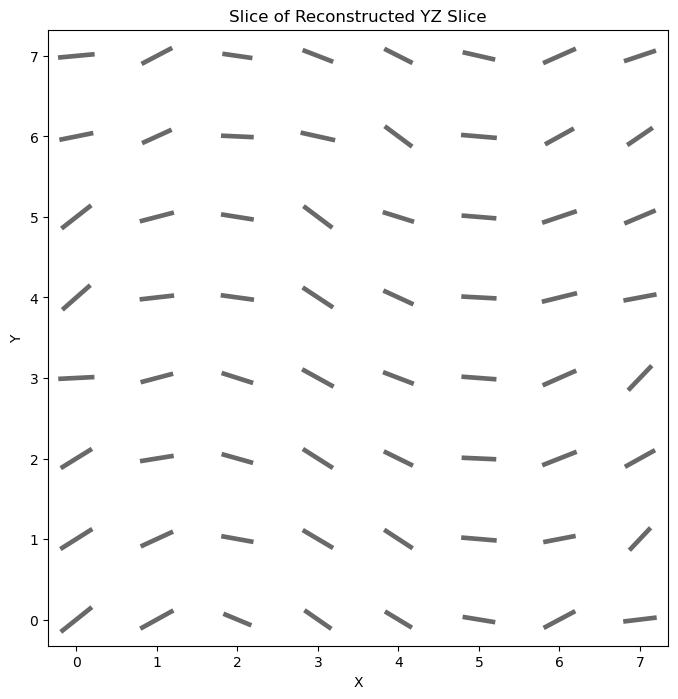

In [56]:
print(np.shape(d3_field[-1][0][0]))
rf.visualize_slice(d3_field[-1][0][0], d3_field[-1][1][0], label='YZ Slice', plotdex='ij')


In [57]:
Ur, Qr, cos2gr, PAr, polr = rf.UQ_reconstruct_3D(bx = d3_field[-1][0], by = d3_field[-1][1], bz = d3_field[-1][2])


In [58]:
def residual2(U_i,Q_i,U_r,Q_r):
    resy = np.sqrt(np.mean((U_i - U_r)**2 + (Q_i - Q_r)**2))
    print(resy)
    return resy

In [59]:
res = residual2(UQpol_array[0], UQpol_array[1], Ur, Qr)
# print(res)

0.4020902766879033


In [ ]:
Ur, Qr, cos2gr, PAr, polr = rf.UQ_reconstruct_3D(bx = d3_field[-1][0], by = d3_field[-1][1], bz = d3_field[-1][1])
res                       = rf.residual(UQpol_array[0], UQpol_array[1], Ur, Qr)
print(res)
exit()
rf.visualize_3d_recon(d3_field[-1][0], d3_field[-1][1], d3_field[-1][2], nskip=2, name='Reconstructed 3D Wavy Field')
print('==== done ====')
